In [1]:
from __future__ import print_function

#Spark and Map-Reduce

##Introduction to Spark

###1: A brief history of big data

####Big Data

Big data is a phrase that has been repeated in the press for the last decade; with an ever-growing torrent of information flowing through the web, it's clear that it's a concept that's becoming increasingly relevant. Companies like Google and Yahoo! have grown their user bases significantly, collecting more information on how their users interact with their products. <a href = "https://en.wikipedia.org/wiki/Moore%27s_law">Moore's law</a> and the rapidly <a href = "https://www.aei.org/wp-content/uploads/2013/04/storage3_f.jpg">falling cost of storage</a> have contributed greatly to this phenomena.

While software companies got better at collecting lots of data, their ability to analyze and make sense of that data didn't keep up at nearly the same pace. Since existing technologies were not built to analyze such large quantities of data, companies like Google, Facebook, Yahoo!, and LinkedIn had to build new paradigms and tools. Engineers tried bigger and more powerful computers to process large amounts of data but ran into limits for many computational problems. Along the way, paradigms like Map-Reduce were developed as a way to efficiently distribute calculations over hundreds or thousands of computers to calculate the result in parallel. Hadoop as an open-source project quickly became the dominant data processing toolkit for big data.

####Hadoop

Hadoop consists of both a filesystem, a distributed file system called HDFS (Hadoop Distributed File System), and its own implementation of the Map-Reduce paradigm. Map-Reduce involves turning the computation you want into Map and Reduce steps that Hadoop could easily distribute over lots of machines. We'll dive more into how Map-Reduce works later in this lesson.

While Hadoop made it possible to analyze large datasets, it still had its limitations. Hadoop relied heavily on disk storage for its computation, which is cheap to store large volumes of data but much <a href = "http://www.cnet.com/news/understanding-ram-versus-hard-drive-space-via-an-analogy/">slower than memory to access</a> and process. Hadoop wasn't a great solution for calculations that required multiple passes over the same data or lots of intermediate steps because of the need to write to and read from disk between each step. This drawback also made Hadoop a interactive data analysis, which is a lot of the work data scientists perform. 

Hadoop also suffered from suboptimal support of additional libraries like SQL and machine learning implementations which many data scientists needed. Once the cost of RAM, or computer memory, started to drop significantly, augmenting or replacing Hadoop by storing data in-memory quickly emerged as an appealing alternative.

###2: Ignite the Spark revolution

After lots of ground-breaking work led by the <a href = "https://amplab.cs.berkeley.edu/projects/spark-lightning-fast-cluster-computing/">UC Berkeley AMP Lab</a>, Spark was developed to utilize distributed, in-memory data structures to improve speeds by orders of magnitude for many data processing workloads. There are wonderful resources online if you are interested in learning more about <a href = "http://blog.cloudera.com/blog/2014/03/why-apache-spark-is-a-crossover-hit-for-data-scientists/">why Spark is a crossover hit for data scientists</a> or read some of the original papers on the <a href = "http://spark.apache.org/research.html">Apache Spark homepage</a>.

###3: Resilient Distributed Datasets (RDD's)

The core data structure in Spark is an RDD, or a resilient distributed dataset. As the name suggests, an RDD is Spark's representation of a dataset that is distributed across the RAM, or memory, of lots of machines. An RDD object is essentially a collection of elements that you can use to hold lists of tuples, dictionaries, lists, etc. Similar to DataFrames in Pandas, you load a dataset into an RDD and then can run any of the methods accesible to that object.

####PySpark

While the Spark toolkit is writen in Scala, a language that compiles down to bytecode for the JVM, the open source community has developed a wonderful toolkit called <a href = "https://spark.apache.org/docs/0.9.0/python-programming-guide.html">PySpark</a> that allows you to interface with RDD's in Python. Thanks to a library called <a href = "https://github.com/bartdag/py4j">Py4J</a>, Python can interface with Java objects, in our case RDD's, and this library one of the tools that makes PySpark work.

To start off, we'll load the dataset containing all of the Daily Show guests into an RDD. We are using the TSV version of <a href = "https://github.com/fivethirtyeight/data/tree/master/daily-show-guests">FiveThirtyEight's dataset</a>. TSV files are separated, or delimited, by a tab character "\t" instead of a comma "," like in a CSV file.

In [2]:
# Set environment variable SPARK_HOME = C:\spark-1.5.0-bin-hadoop2.6

# Configure the necessary Spark environment
import os
import sys

spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, spark_home + "/python")

# Add the py4j to the path.
# You may need to change the version number to match your install
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))

# Initialize PySpark to predefine the SparkContext variable 'sc'
filename = os.path.join(spark_home, 'python/pyspark/shell.py')
#execfile(filename)
exec(compile(open(filename, "rb").read(), filename, 'exec'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.1
      /_/

Using Python version 3.4.3 (default, Oct 28 2015 15:59:18)
SparkContext available as sc, HiveContext available as sqlContext.


###4: SparkContext

SparkContext is the object that manages the connection to the clusters in Spark and coordinates running processes on the clusters themselves. SparkContext connects to cluster managers, which manage the actual executors that run the specific computations. Here's a diagram from the Spark documentation to better visualize the architecture:

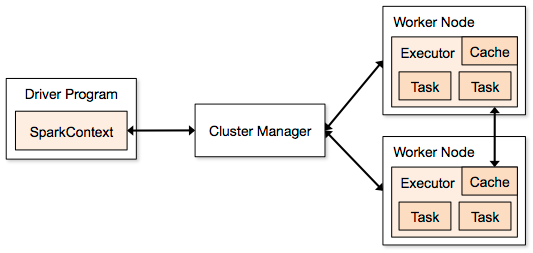

In [3]:
from IPython.display import Image

Image(filename='sparkarch.png') 

The SparkContext object sc is automatically setup on our end:

In [4]:
sc

We then run sc.textFile() to read the TSV dataset into an RDD object raw_data. The RDD object raw_data closely resembles a List of String objects, one object for each line in the dataset:

In [5]:
raw_data = sc.textFile("data/daily_show_guests.tsv")

We then use the take() method to print the first 5 elements of the RDD:

In [6]:
raw_data.take(5)

['YEAR\tGoogleKnowlege_Occupation\tShow\tGroup\tRaw_Guest_List',
 '1999\tactor\t1/11/1999\tActing\tMichael J. Fox',
 '1999\tComedian\t1/12/1999\tComedy\tSandra Bernhard',
 '1999\ttelevision actress\t1/13/99\tActing\tTracey Ullman',
 '1999\tfilm actress\t1/14/99\tActing\tGillian Anderson']

###5: Lazy Evaluation

One question you may have is if an RDD resembles a Python List, why not just use bracket notation to access elements in the RDD? Because RDD objects are distributed across lots of partitions, we can't rely on the standard implementation of a List and the RDD object was developed to specifically handle the distributed nature of the data. One advantage of the RDD abstraction is the ability to run Spark locally on your own computer. When running locally on your own computer, Spark simulates distributing your calculations over lots of machines by slicing your computer's memory into partitions, with no tweaking or changes to the code you wrote.

Another advantage of Spark's RDD implementation is the ability to lazily evaluate code, postponing running a calculation until absolutely necessary. In the above code cell, Spark didn't wait to load the TSV file into an RDD until raw_data.take(5) was run. When raw_data = sc.textFile("dail_show.tsv") was called, a pointer to the file was created, but only when raw_data.take(5) needed the file to run its logic was the text file actually read into raw_data.

###6: Pipelines

The key idea to understand when working with Spark is data pipelining. Every operation or calculation in Spark is essentially a series of steps that can be chained together and run in succession to form a pipeline. Each step in the pipeline returns either a Python value (e.g. Integer), a Python data structure (e.g. Dictionary) or an RDD object. We'll first start with the map() function.

####Map()

The map(f) function applies the function f to every element in the RDD. Since RDD's are iterable objects, like most Python objects, Spark runs function f on every iteration and returns a new RDD.

We'll walk through a map example so you can get a better sense. If you look carefully, raw_data is in a format that's hard to work with. While currently each element is a String, we'd like to transform every element into a List so the data is more managable.

In the below code cell, we:
1. Call the RDD function `map()` to specify we want the enclosed logic to be applied to every line in our dataset
2. Write a lambda function to split each line using the tab delimiter "\t" and assign the resulting RDD to `daily_show`
3. Call the RDD function `take()` on `daily_show` to display the first 5 elements (or rows) of the resulting RDD

The map(f) function is known as a transformation step and either a named or lambda function f is required.

In [7]:
daily_show = raw_data.map(lambda line: line.split('\t'))
daily_show.take(5)

[['YEAR', 'GoogleKnowlege_Occupation', 'Show', 'Group', 'Raw_Guest_List'],
 ['1999', 'actor', '1/11/1999', 'Acting', 'Michael J. Fox'],
 ['1999', 'Comedian', '1/12/1999', 'Comedy', 'Sandra Bernhard'],
 ['1999', 'television actress', '1/13/99', 'Acting', 'Tracey Ullman'],
 ['1999', 'film actress', '1/14/99', 'Acting', 'Gillian Anderson']]

###7: Python and Scala, friends forever

One of the wonderful features of PySpark is the ability to separate our logic, which we prefer to write in Python, from the actual data transformation. In the above code cell, we wrote a lambda function in Python code:

raw_data.map(lambda: line(line.split('\t')))

but got to take advantage of Scala when Spark actually ran the code over our RDD. This is the power of PySpark. Without learning any Scala, we get to harness the data processing performance gains from Spark's Scala architecture. Even better, when we ran:

daily_show.take(5)

the results were returned to us in Python friendly notation.

####Transformations and Actions

In Spark, there are two types of methods:

1. Transformations - map(), reduceByKey()
2. Actions - take(), reduce(), saveAsTextFile(), collect()

Transformations are lazy operations and always return a reference to an RDD object. The transformation, however, is not actually run until an action needs to use the resulting RDD from a transformation. Any function that returns an RDD is a transformation and any function that returns a value is an action. These concepts will become more clear as you work through this lesson and practice writing PySpark code.

####Immutability

You may be wondering why we couldn't just split each String in place instead of creating a new object daily_show? In Python, we could have modified the collection element-by-element in place without returning and assignign to a new object.

RDD objects are <a href = "https://www.quora.com/Why-is-a-spark-RDD-immutable">immutable</a> and their values can't be changed once the object is created. In Python, List objects and Dictionary objects are mutable, which means we can change the object's values, while Tuple objects are immutable. The only way to modify a Tuple object in Python is to create a new Tuple object with the necessary updates. Spark utilizes immutability of RDD's for speed gains.

###8: ReduceByKey()

We would like to get a histogram, or a tally, of the number of guests in each year the show has been running. If daily_show were a List of Lists, we could write the following Python code to achieve this result:

tally = dict()
for line in daily_show:
  year = line[0]
  if year in tally.keys():
    tally[year] = tally[year] + 1
  else:
    tally[year] = 1

The keys in tally will be unique Year values and the values will be the number of lines in the dataset that contained that value. 

If we want to achieve this same result using Spark, we will have to use a Map step followed by a ReduceByKey step.

In [8]:
tally = daily_show.map(lambda x: (x[0], 1)).reduceByKey(lambda x,y: x+y)
print(tally)

PythonRDD[8] at RDD at PythonRDD.scala:43


###9: Explanation

You may notice that printing tally didn't return the histogram we were hoping for. Because of lazy evaluation, PySpark delayed executing the map and reduceByKey steps until we actually need it. Before we use take() to preview the first few elements in tally, we'll walk through the code we just wrote.

    daily_show.map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x+y)

During the map step, we used a lambda function to create a tuple consisting of:
- key: x[0], the first value in the List 
- value: 1, the int

Our high level strategy was to create a tuple with the key representing the Year and the value representing 1. After the map step, Spark will maintain in memory a list of tuples resembling the following:

    ('YEAR', 1)
    ('1991', 1)
    ('1991', 1)
    ('1991', 1)
    ('1991', 1)
    ...

and we'd like to reduce that down to:

    ('YEAR', 1)
    ('1991', 4)
    ...

reduceByKey(f) combines tuples with the same key using the function we specify f.

To see the results of these 2 steps, we'll use the take command, which forces lazy code to run immediately. Since tally is an RDD, we can't use Python's len function to know how many elements are in the collection and will instead need to use the RDD count() function.

In [9]:
tally.take(tally.count())

[('YEAR', 1),
 ('2012', 164),
 ('2013', 166),
 ('2004', 164),
 ('2011', 163),
 ('2014', 163),
 ('2002', 159),
 ('2007', 141),
 ('2015', 100),
 ('2003', 166),
 ('2010', 165),
 ('2001', 157),
 ('2000', 169),
 ('2008', 164),
 ('2005', 162),
 ('2009', 163),
 ('1999', 166),
 ('2006', 161)]

###10: Filter

Unlike Pandas, Spark knows nothing about column headers and didn't set them aside. We need a way to get rid of the element:

    ('YEAR', 1)

from our collection. While you may be tempted to try to find a way to remove this element from the RDD, recall that RDD objects are immutable and can't be changed once created. The only way to remove that tuple is to create a new RDD object without that tuple.

Spark comes with a function filter(f) that allows us to create a new RDD from an existing one containing only the elements meeting our criteria. Specify a function f that returns a binary value, True or False, and the resulting RDD will consist of elements where the function evaluated to True. Read more about the filter function over at <a href = "https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html#filter">Spark's documentation</a>.

####Instructions

Write a function filter_year that can be used to filter the element containing the value YEAR as the first value instead of an actual year.

In [10]:
def filter_year(line):
    if line[0] == 'YEAR':
        return False
    else:
        return True

filtered_daily_show = daily_show.filter(lambda line: filter_year(line))

###11: All together now

To flex Spark's muscles, we'll demonstrate how to chain together a series of data transformations into a pipeline and observe Spark managing everything in the background. Spark was written with this functionality in mind and is highly optimized for running tasks in succession. Previously, running lots of tasks in succession in Hadoop was incredibly time consuming since intermediate results needed to be written to disk and Hadoop wasn't aware of the full pipeline. 

Thanks to Spark's aggressive usage of memory (and only disk as a backup and for specific tasks) and well architected core, Spark is able to improve significantly on Hadoop's turnaround time. In the following code cell, we'll filter out actors with no profession listed, lowercase each profession, generate a histogram of professions, and output the first 5 tuples in the histogram.

In [11]:
filtered_daily_show.filter(lambda line: line[1] != '') \
                   .map(lambda line: (line[1].lower(), 1)) \
                   .reduceByKey(lambda x,y: x+y) \
                   .take(5)

[('radio personality', 3),
 ('former governor of new york', 1),
 ('illustrator', 1),
 ('presidnet', 3),
 ('former united states secretary of state', 6)]

###12: Next steps

When working with larger datasets, PySpark really shines since it blurs the line between doing data science locally on your own computer and doing data science using large amounts of distributed computing on the internet (also referred to as the cloud).

If you'd like to learn how to install PySpark and integrate it with IPython Notebook, read <a href = "http://ramhiser.com/2015/02/01/configuring-ipython-notebook-support-for-pyspark/">this wonderful blog post</a> that walks you through the steps.